<table><tr>
<td> <img src=https://www.baltimorepolice.org/themes/custom/bpd/images/bpd_logo.png alt="Drawing" style="height: 250px;"/> </td>
<td> <img src=https://beam-images.warnermediacdn.com/BEAM_LWM_DELIVERABLES/1bc3aff5-0d6a-4c0b-8ed0-5716ca30ab3b/fbbc7a604f327cfa8a7bbe614a89be13a246d266.jpg?host=wbd-images.prod-vod.h264.io&partner=beamcom style="height: 250px;"/> </td>
</tr></table>

PRUEBAS DE MODELADO
=
- RandomForestClassifier 
- RandomForest + RandomOverSample
- RandomForest + PCA
- XGBoost + RandomOverSample
- Support Vector Machines (SVM)
- K-Nearest Neighbors (KNN)
- nn_model

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Cargar el dataset
df = pd.read_csv('New_BPD.csv')

RANDOM FOREST
=

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.10      0.17        82
           1       1.00      0.04      0.08        24
           2       0.58      0.81      0.67      2555
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         7
           5       0.65      0.22      0.32       291
           6       1.00      0.08      0.15        12
           7       0.72      0.90      0.80      7898
           8       0.55      0.14      0.22      1382
           9       0.66      0.14      0.24       188
          10       0.69      0.08      0.14       272
          11       0.55      0.40      0.46       129
          12       0.00      0.00      0.00         5
          13       0.43      0.16      0.23      1881
          14       1.00      0.12      0.21        60

    accuracy                           0.67     14789
   macro avg       0.57      0.21      0.25     14789
wei

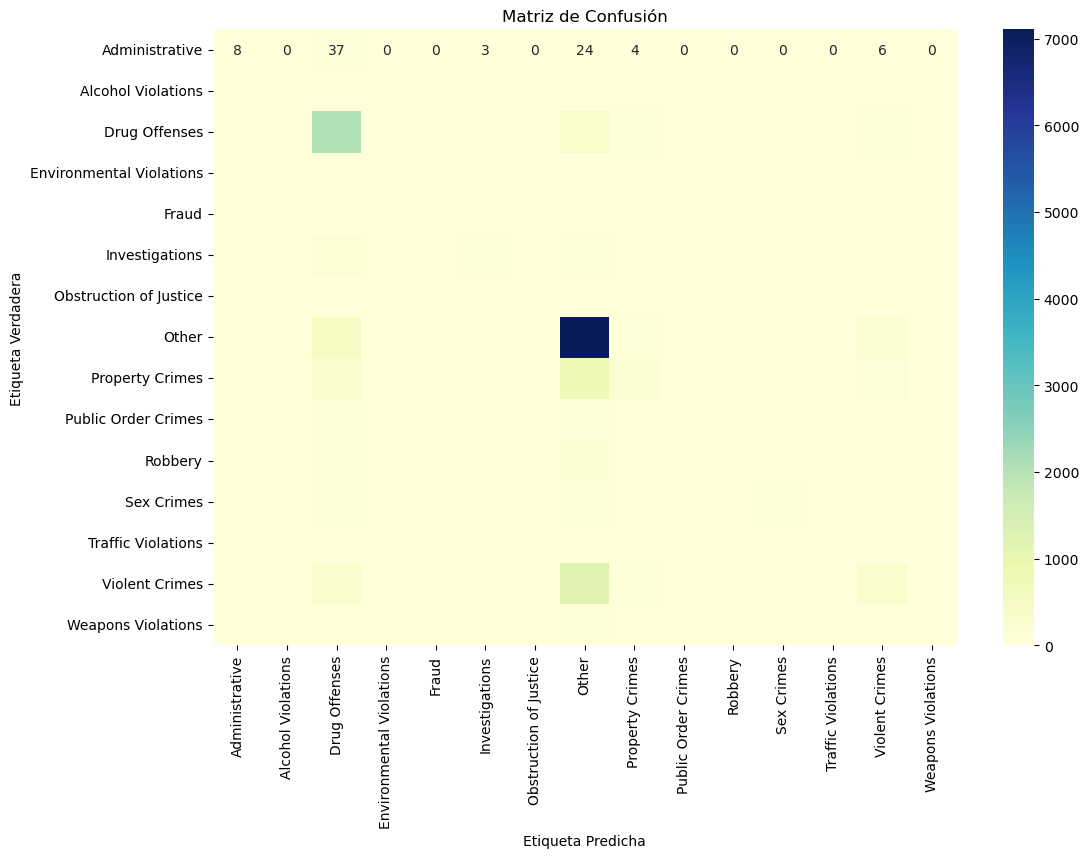

In [17]:
# Convertir variables categóricas a numéricas con LabelEncoder
label_encoder_race = LabelEncoder()
df['Race'] = label_encoder_race.fit_transform(df['Race'])

label_encoder_district = LabelEncoder()
df['District'] = label_encoder_district.fit_transform(df['District'])

label_encoder_offense = LabelEncoder()
df['OffenseCategory'] = label_encoder_offense.fit_transform(df['OffenseCategory'])

# Convertir variables categóricas a variables dummy (One-Hot Encoding) para las columnas que no se han codificado
df = pd.get_dummies(df, columns=['Sex'])

# Seleccionar características y etiqueta
X = df.drop('OffenseCategory', axis=1)
y = df['OffenseCategory']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred = rf_model.predict(X_test_scaled)

# Evaluar el modelo con zero_division=0 para evitar warnings
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Calcular la matriz de confusión asegurando que todas las clases estén representadas
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.arange(len(label_encoder_offense.classes_)))

print("Confusion Matrix:")
print(conf_matrix)

# Crear un DataFrame con la matriz de confusión para la visualización
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=label_encoder_offense.classes_,
                              columns=label_encoder_offense.classes_)

# Visualizar la matriz de confusión con seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()


RandomForest + RandomOverSample
=

In [18]:
# Aplicar RandomOverSampler al conjunto de entrenamiento
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Entrenar el modelo con los datos balanceados
model_ros = RandomForestClassifier(n_estimators=100, random_state=42)
model_ros.fit(X_train_ros, y_train_ros)

# Evaluar el modelo
y_pred_ros = model_ros.predict(X_test)
print("Random Forest with RandomOverSampler:")
print(classification_report(y_test, y_pred_ros))
print(confusion_matrix(y_test, y_pred_ros))

Random Forest with RandomOverSampler:


C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

          Administrative       0.46      0.10      0.17       128
      Alcohol Violations       1.00      0.03      0.05        38
           Animal Crimes       0.00      0.00      0.00         2
                   Arson       1.00      0.33      0.50         3
             Child Abuse       0.00      0.00      0.00        17
         Domestic Crimes       0.27      0.05      0.08        84
           Drug Offenses       0.56      0.82      0.66      3916
Environmental Violations       0.00      0.00      0.00         3
          Fire Incidents       0.00      0.00      0.00         3
                   Fraud       1.00      0.12      0.22         8
          Investigations       0.65      0.29      0.40       443
     Medical Emergencies       0.00      0.00      0.00         7
           Mental Health       0.33      0.14      0.20         7
  Obstruction of Justice       1.00      0.13      0.24        15
         

RandomForestClassifier + PCA
=

In [16]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Limpieza de datos
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Selección de características y etiquetas
X = df.drop('OffenseCategory', axis=1)
y = df['OffenseCategory']

# Identificar características numéricas y categóricas
numeric_features = ['Age', 'Year', 'Month', 'DayOfWeek', 'Hour', 'Latitude', 'Longitude']
categorical_features = ['Sex', 'Race', 'District']

# Crear el preprocesador con PCA
preprocessor = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features)
        ]
    )),
    ('pca', PCA(n_components=0.95))  # Mantener el 95% de la varianza
])

# Crear el pipeline con PCA y RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ajustar y evaluar el modelo
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Random Forest con PCA:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Random Forest con PCA:


C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

          Administrative       0.60      0.02      0.05       128
      Alcohol Violations       1.00      0.03      0.05        38
           Drug Offenses       0.54      0.76      0.63      3916
Environmental Violations       0.00      0.00      0.00         3
                   Fraud       0.00      0.00      0.00         8
          Investigations       0.53      0.12      0.20       443
  Obstruction of Justice       0.00      0.00      0.00        15
                   Other       0.69      0.89      0.78     11750
         Property Crimes       0.43      0.06      0.11      2061
     Public Order Crimes       0.58      0.08      0.15       265
                 Robbery       0.70      0.04      0.08       386
              Sex Crimes       0.37      0.16      0.22       200
      Traffic Violations       0.00      0.00      0.00        12
          Violent Crimes       0.37      0.10      0.16      2853
      Wea

C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBoost + RandomOverSample
=

In [20]:
# XGBoost
# Codificar las etiquetas de clase
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_ros)
y_test_encoded = label_encoder.transform(y_test)

# Inicializar y entrenar el clasificador XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_ros, y_train_encoded)

# Hacer predicciones
y_pred_xgb_encoded = xgb_model.predict(X_test)

# Decodificar las etiquetas predichas
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

# Evaluar el modelo
print("XGBoost with RandomOverSampler:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))



C:\Users\TONAC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost with RandomOverSampler:


C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TONAC\anaconda3\Lib\site-packages\sklea

                          precision    recall  f1-score   support

          Administrative       0.11      0.18      0.14       128
      Alcohol Violations       0.08      0.08      0.08        38
           Animal Crimes       0.00      0.00      0.00         2
                   Arson       0.00      0.00      0.00         3
             Child Abuse       0.33      0.06      0.10        17
         Domestic Crimes       0.07      0.12      0.08        84
           Drug Offenses       0.59      0.63      0.61      3916
Environmental Violations       0.00      0.00      0.00         3
          Fire Incidents       0.00      0.00      0.00         3
                   Fraud       0.25      0.12      0.17         8
       Human Trafficking       0.00      0.00      0.00         0
          Investigations       0.21      0.55      0.30       443
     Medical Emergencies       0.50      0.14      0.22         7
           Mental Health       0.40      0.29      0.33         7
  Obstruc

Support Vector Machines (SVM)
=

- Puede manejar el desbalance de clases mediante el ajuste de los pesos de las clases.
- Es muy útil cuando hay muchos aspectos diferentes en los datos, ya que puede manejarlos de manera efectiva usando técnicas especiales llamadas kernels.

In [67]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Aplicar RandomOverSampler al conjunto de entrenamiento
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Inicializar y entrenar el clasificador SVM
svm_model = SVC(class_weight='balanced', random_state=42)
svm_model.fit(X_train_ros, y_train_ros)

# Hacer predicciones y evaluar el modelo
y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))


C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

          Administrative       0.00      0.00      0.00       128
      Alcohol Violations       0.00      0.18      0.01        38
           Drug Offenses       0.00      0.00      0.00      3916
Environmental Violations       0.00      0.67      0.00         3
                   Fraud       0.00      0.38      0.00         8
          Investigations       0.00      0.00      0.00       443
  Obstruction of Justice       0.00      0.00      0.00        15
                   Other       0.00      0.00      0.00     11750
         Property Crimes       0.00      0.00      0.00      2061
     Public Order Crimes       0.00      0.00      0.00       265
                 Robbery       0.00      0.00      0.00       386
              Sex Crimes       0.00      0.00      0.00       200
      Traffic Violations       0.00      0.08      0.00        12
          Violent Crimes       0.00      0.00      0.00      2853
      Wea

K-Nearest Neighbors (KNN)
=

- Puede ser útil para problemas con características de alta dimensionalidad.

In [22]:
# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_ros, y_train_ros)

# Hacer predicciones y evaluar el modelo
y_pred_knn = knn_model.predict(X_test)
print("K-Nearest Neighbors with RandomOverSampler:")
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))

K-Nearest Neighbors with RandomOverSampler:


C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

          Administrative       0.05      0.09      0.07       128
      Alcohol Violations       0.02      0.03      0.02        38
           Animal Crimes       0.00      0.00      0.00         2
                   Arson       0.00      0.00      0.00         3
             Child Abuse       0.00      0.00      0.00        17
         Domestic Crimes       0.04      0.07      0.05        84
           Drug Offenses       0.37      0.54      0.44      3916
Environmental Violations       0.00      0.00      0.00         3
          Fire Incidents       0.00      0.00      0.00         3
                   Fraud       0.00      0.00      0.00         8
          Investigations       0.10      0.17      0.13       443
     Medical Emergencies       0.00      0.00      0.00         7
           Mental Health       0.00      0.00      0.00         7
  Obstruction of Justice       0.00      0.00      0.00        15
         

Deep Learning (neural network)
=

In [23]:
# Deep Learning
# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ros)
X_test_scaled = scaler.transform(X_test)

# Construir el modelo
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(set(y_train_encoded)), activation='softmax')
])

nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
nn_model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Hacer predicciones y evaluar el modelo
y_pred_nn_encoded = nn_model.predict(X_test_scaled)
y_pred_nn = y_pred_nn_encoded.argmax(axis=1)  # Obtener las clases predichas

# Decodificar las etiquetas predichas
y_pred_nn_decoded = label_encoder.inverse_transform(y_pred_nn)

# Evaluar el modelo
print("Deep Learning with RandomOverSampler:")
print(classification_report(y_test, y_pred_nn_decoded))
print(confusion_matrix(y_test, y_pred_nn_decoded))

C:\Users\TONAC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
16469/16469 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.5958 - loss: 1.2849 - val_accuracy: 0.0022 - val_loss: 9.9972
Epoch 2/10
16469/16469 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.7248 - loss: 0.7800 - val_accuracy: 0.0046 - val_loss: 10.4239
Epoch 3/10
16469/16469 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.7469 - loss: 0.7190 - val_accuracy: 0.0040 - val_loss: 9.3591
Epoch 4/10
16469/16469 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.7614 - loss: 0.6810 - val_accuracy: 0.0096 - val_loss: 8.9471
Epoch 5/10
16469/16469 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.7706 - loss: 0.6535 - val_accuracy: 0.0069 - val_loss: 8.5443
Epoch 6/10
16469/16469 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.7760 - loss: 0.6377 - val_accuracy: 0.0202 - val_loss: 7.9886
Epoch 7/10
16469/16469 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.7823 - loss: 0.6207 - val_accuracy: 0.0043 - val_loss: 8.8543
Epoch 8/10
16469/16469 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy:

C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TONAC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

          Administrative       0.01      0.20      0.02       128
      Alcohol Violations       0.03      0.18      0.06        38
           Animal Crimes       0.00      0.00      0.00         2
                   Arson       0.02      0.33      0.04         3
             Child Abuse       0.00      0.00      0.00        17
         Domestic Crimes       0.01      0.04      0.01        84
           Drug Offenses       0.52      0.39      0.45      3916
Environmental Violations       0.00      0.00      0.00         3
          Fire Incidents       0.00      0.00      0.00         3
                   Fraud       0.00      0.00      0.00         8
          Investigations       0.09      0.35      0.15       443
     Medical Emergencies       0.00      0.00      0.00         7
           Mental Health       0.04      0.29      0.07         7
  Obstruction of Justice       0.03      0.13      0.05        15
         

Explicación del Rendimiento del Modelo
=

- En el análisis he obtenido una precisión global de 0.67 para el modelo Random Forest Classifier.
- Clases Desbalanceadas: Las métricas de precisión, recall y F1-score varían significativamente entre las diferentes clases.
- El modelo tiene un rendimiento desigual en diferentes clases.

Análisis de la Matriz de Confusión
=
- Errores de Clasificación: el modelo tiene dificultades para clasificar correctamente muchas clases, particularmente aquellas con pocas instancias.
Las clases con más instancias están clasificadas con una mayor precisión y exhaustividad.

Posibles Razones para el Rendimiento Actual
=
Desbalance de Clases: Aunque he utilizado técnicas como SMOTE o PCA para equilibrar las clases, el modelo aún está sesgado hacia las clases con más instancias. La falta de suficientes datos para las clases minoritarias hace que el modelo no generalice bien para esas clases.

Trabajo a futuro
=
Para mejorar el rendimiento del modelo, podemos considerar:

- Explorar Técnicas de Modelado Adicionales

- Ajuste de Hiperparámetros

- Mejorar la Calidad de los Datos

En resumen, aunque los resultados no alcanzaron niveles de precisión elevados, reflejan la complejidad del problema y las limitaciones que tenemos por la calidad y naturaleza de los datos disponibles. Podría hacer  futuras investigaciones que se centrasen en la obtención de datos más ricos y en la aplicación de técnicas avanzadas de preprocesamiento y modelado para superar estas limitaciones.

* Tenemos un 60% de las localizaciones (barrio, código postal, localización por coordenadas) de los arrestos pero no sabemos el orígen de los detenidos.
* Tampoco sabemos si los detenidos fueron finalmente condenados en sentencia firme.